Embedding analysis:
Shape: (258, 768)
Mean: 0.0008
Std: 0.5439
Min: -2.1526
Max: 2.2051


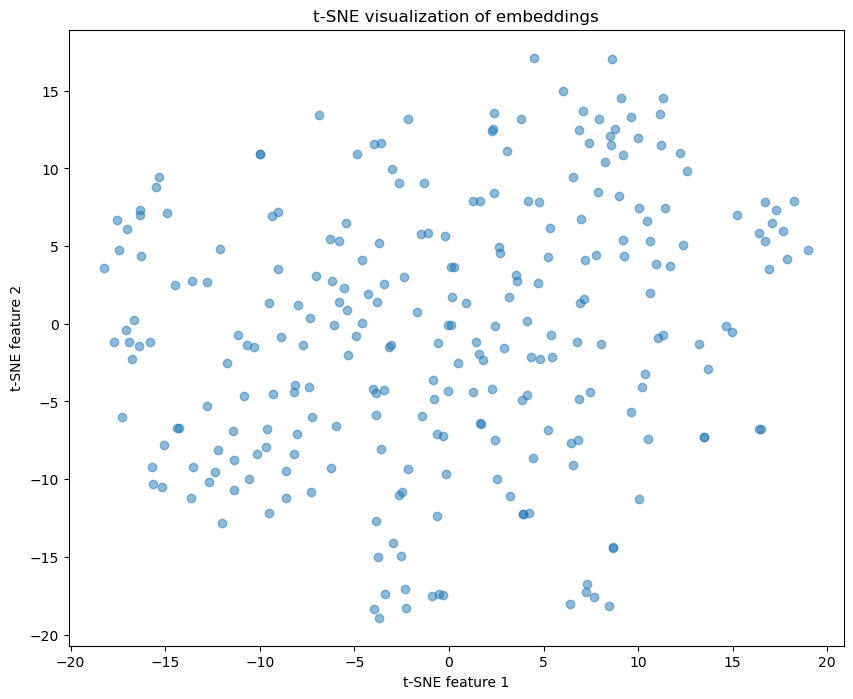


Hierarchical Clustering:


Trying linkage methods:   0%|          | 0/4 [00:00<?, ?it/s]

Best Silhouette Score: 0.2417
Best Parameters: {'method': 'ward', 'metric': 'euclidean', 'distance_threshold': 8.6}
Number of Clusters: 87


In [4]:
import json
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE

def analyze_embeddings(embeddings):
    print("Embedding analysis:")
    print(f"Shape: {embeddings.shape}")
    print(f"Mean: {np.mean(embeddings):.4f}")
    print(f"Std: {np.std(embeddings):.4f}")
    print(f"Min: {np.min(embeddings):.4f}")
    print(f"Max: {np.max(embeddings):.4f}")

def visualize_embeddings(embeddings):
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)
    plt.title("t-SNE visualization of embeddings")
    plt.xlabel("t-SNE feature 1")
    plt.ylabel("t-SNE feature 2")
    plt.show()

def optimize_hierarchical_clustering(embeddings):
    best_score = -1
    best_params = {}
    best_labels = None
   
    linkage_methods = ['ward', 'complete', 'average', 'single']
    distance_metrics = ['euclidean', 'cosine']
   
    for method in tqdm(linkage_methods, desc="Trying linkage methods"):
        for metric in distance_metrics:
            if method == 'ward' and metric != 'euclidean':
                continue  # Ward method only works with euclidean distance
           
            Z = linkage(embeddings, method=method, metric=metric)
           
            for distance_threshold in np.arange(0.1, 10.0, 0.1):  # Extended range
                labels = fcluster(Z, t=distance_threshold, criterion='distance')
               
                if 2 <= len(set(labels)) <= 200:  # Increased upper limit
                    score = silhouette_score(embeddings, labels, metric='cosine')
                    if score > best_score:
                        best_score = score
                        best_params = {
                            'method': method,
                            'metric': metric,
                            'distance_threshold': distance_threshold
                        }
                        best_labels = labels
   
    if best_score == -1:
        print("No valid clustering solution found. Try adjusting the parameters.")
        return None, None, None
    
    return best_score, best_params, best_labels

# Load the embedded bookmarks
with open('embedded_bookmarks.json') as f:
    data = json.load(f)

embeddings = np.array([bookmark["embedding"] for bookmark in data])

# Analyze embeddings
analyze_embeddings(embeddings)

# Visualize embeddings
visualize_embeddings(embeddings)

# Reduce dimensions
svd = TruncatedSVD(n_components=50, random_state=42)
embeddings_reduced = svd.fit_transform(embeddings)

print("\nHierarchical Clustering:")
hier_score, hier_params, hier_labels = optimize_hierarchical_clustering(embeddings_reduced)

if hier_score is not None:
    print(f"Best Silhouette Score: {hier_score:.4f}")
    print(f"Best Parameters: {hier_params}")
    print(f"Number of Clusters: {len(set(hier_labels))}")
else:
    print("Clustering failed. Please check your data and parameters.")